In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras_core import callbacks
import keras_core
#from keras_core import layers
#from keras_core import optimizers
from keras import layers
from keras import optimizers
import keras_tuner
from tensorflow_probability import distributions as tfd


Using TensorFlow backend





#### Data pre-process and visualization

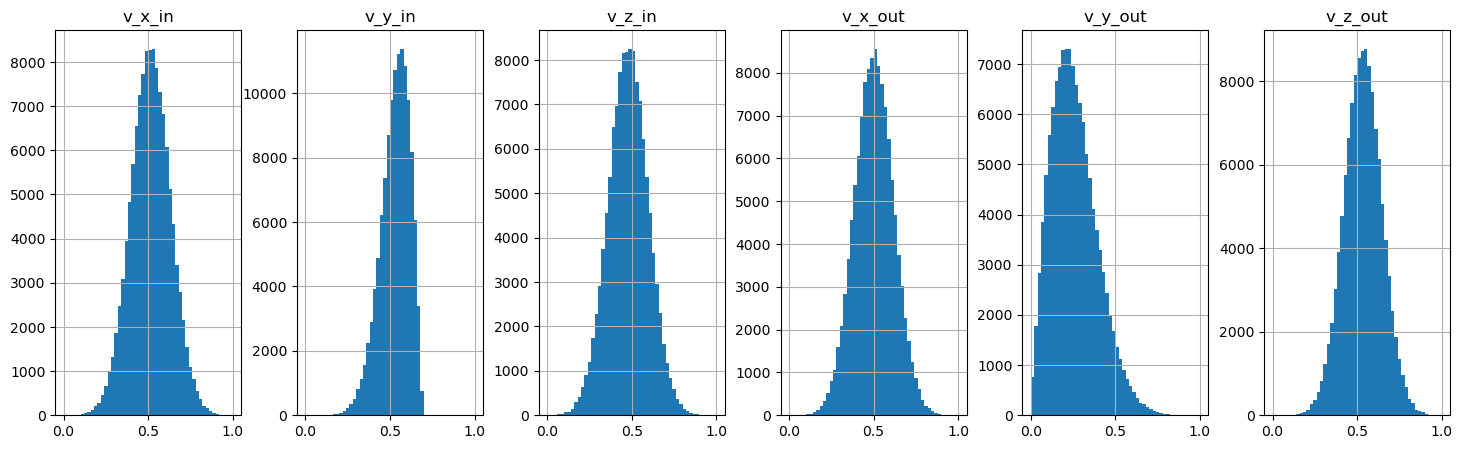

In [32]:
filename = 'D:/OneDrive - TU Eindhoven/Quartile_4/4AI000_Machine learning for Multi-physics modelling and design/Materials_for_ML_assignment_2024/H2_IsoThermalWalls_Sw_0/H2_Vel_MD_Sw_0_B300_Th_300.txt'
names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)


x = df_trans_vel.loc[:, ].values
x_norm = MinMaxScaler().fit_transform(x) # normalizing the features

# Creating Dataframe of normalized values
df_trans_vel_norm = pd.DataFrame(x_norm,columns=names_trans_vel)

df_trans_vel_norm.hist(bins = 50, layout= (1,6), figsize= (18,5))

x = df_trans_vel_norm[['v_y_in']].to_numpy()
y = df_trans_vel_norm[['v_y_out']].to_numpy()


### Selected components 

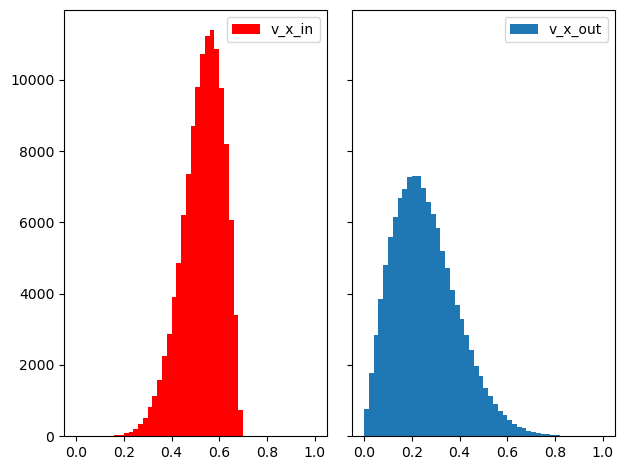

In [33]:
n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(x, bins=n_bins, label = 'v_x_in', color = 'r')
axs[1].hist(y, bins=n_bins, label = 'v_x_out')
axs[0].legend()
axs[1].legend()
plt.show()

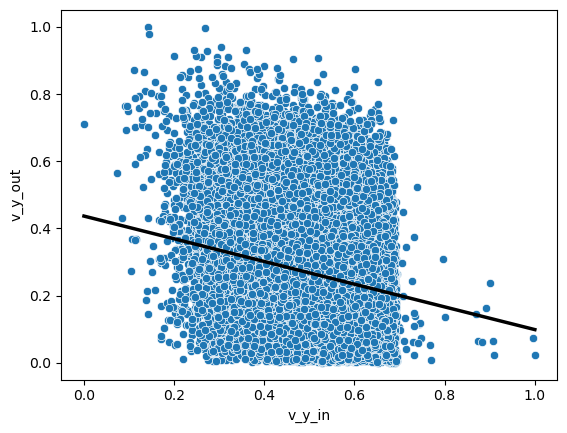

In [34]:
fig, ax = plt.subplots()

# Add scatterplot
sns.scatterplot(df_trans_vel_norm, x = "v_y_in", y = 'v_y_out')
a = [i[0] for i in x]
b = [i[0] for i in y]
m, c = np.polyfit(a, b, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(min(a), max(a), num=100)

# Plot regression line
ax.plot(xseq, c + m * xseq, color="k", lw=2.5)


In [35]:
def elu_plus_one_plus_epsilon(x):
    return keras_core.activations.elu(x) + 1 + keras_core.backend.epsilon()

class MixtureDensityOutput(layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        )  # mix*output vals, no activation
        self.mdn_sigmas = layers.Dense(
            self.num_mix * self.output_dim,
            activation=elu_plus_one_plus_epsilon,
            name="mdn_sigmas",
        )  # mix*output vals exp activation
        self.mdn_pi = layers.Dense(self.num_mix, name="mdn_pi")  # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )

    def call(self, x, mask=None):
        return layers.concatenate(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], name="mdn_outputs"
        )
    
def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = tf.reshape(
            y_pred,
            [-1, (2 * num_mixes * output_dim) + num_mixes],
            name="reshape_ypreds",
        )
        y_true = tf.reshape(y_true, [-1, output_dim], name="reshape_ytrue")
        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            num_or_size_splits=[
                num_mixes * output_dim,
                num_mixes * output_dim,
                num_mixes,
            ],
            axis=-1,
            name="mdn_coef_split",
        )
        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [
            tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
            for loc, scale in zip(mus, sigs)
        ]
        mixture = tfd.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    return mdn_loss_func





#### Build and compile model

In [36]:
N_HIDDEN = 50

OUTPUT_DIMS = 1
N_MIXES = 40


mdn_network = keras.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dropout(0.2),
        MixtureDensityOutput(OUTPUT_DIMS, N_MIXES),
    ]
)

loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = "adam"

mdn_network.compile(loss= loss_function, optimizer= optimizer)


### Training the MDN

In [37]:
history = mdn_network.fit(
    x,
    y,
    epochs=100,
    batch_size = 256,
    validation_split=0.15,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - loss: 0.0580 - val_loss: -0.6126 - learning_rate: 0.0010
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: -0.5818 - val_loss: -0.6384 - learning_rate: 0.0010
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.6206 - val_loss: -0.6437 - learning_rate: 0.0010
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: -0.6309 - val_loss: -0.6482 - learning_rate: 0.0010
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: -0.6382 - val_loss: -0.6431 - learning_rate: 0.0010
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: -0.6411 - val_loss: -0.6471 - learning_rate: 0.0010
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: -0.6416 - val_loss: -0.6497 - learning_rate: 0.0010
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: -0.6429 - val_loss: -0.6481 - learning_rate: 0.0010
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: -0.6392 - val_loss: -0.6479 - lea

### Hyperparameter tuning - Defining search space and type of optimization

In [25]:
def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, lr = 0.001, optimizer = ""):
    model =  keras.Sequential()
    
    for i in range(1, num_Layers+1):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=activation)
        )
        if dropout:
            model.add(layers.Dropout(dropout_rate))   
    
    model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'AdamW':
        optimizer = optimizers.AdamW(learning_rate=lr)
    elif optimizer == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=lr)        
    else:
        optimizer = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer = optimizer,
        loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
    )
    return model

# Define hyper-parameter search space
def build_model(hp):

    # Choices for number of Mixtures - an important advantage of using MDN
    num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=100, step=1)
    
    # Choices for number of layers, excluding output layer
    num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

    # Choices of activation
    activation = hp.Choice("activation", ["relu", "tanh"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
    # Choice on dropout
    dropout = hp.Boolean("dropout", default = True)

    # Choices on dropout rate
    dropout_rate = hp.Float("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

    # Choices on learning rate
    optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
    # Call existing model-building code with the hyperparameter values.
    mdn_network = model(
        hp, num_Mixes=num_Mixes, 
        num_Layers=num_Layers, 
        activation=activation, 
        dropout_rate= dropout_rate, 
        dropout=dropout,  
        optimizer = optimizer
    )
    return mdn_network


build_model(keras_tuner.HyperParameters())

# Directory to store the models during hyper-parameter tuning 
directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

tuner = keras_tuner.BayesianOptimization(
    hypermodel= build_model,
    max_trials= 40,
    objective = "loss",
    alpha=0.0001,
    beta=2.6,
    seed= 1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    project_name="models_4AI000",
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
num_Mixes (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': True, 'conditions': []}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.2, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'Nadam', 'Adadelta'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [10]:
# def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, optimizer = ""):
#     model =  keras.Sequential()
    
#     for i in range(1, num_Layers+1):
#         model.add(
#             layers.Dense(
#                 units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
#                 activation=activation)
#         )
#         if dropout:
#             model.add(layers.Dropout(dropout_rate=0.2))   
    
#     model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

#     if optimizer == 'Adam':
#         optimizer = optimizers.Adam(learning_rate=lr)
#     elif optimizer == 'AdamW':
#         optimizer = optimizers.AdamW(learning_rate=lr)
#     elif optimizer == 'Nadam':
#         optimizer = optimizers.Nadam(learning_rate=lr)
#     elif optimizer == 'Adadelta':
#         optimizer = optimizers.Adadelta(learning_rate=lr)        
#     else:
#         optimizer = optimizers.Adam(learning_rate=lr)

#     model.compile(
#         optimizer = optimizer,
#         loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
#     )
#     return model

# # Define hyper-parameter search space
# def build_model(hp):

#     # Choices for number of Mixtures - an important advantage of using MDN
#     num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=50, step=1)
    
#     # Choices for number of layers
#     num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

#     # Choices of activation
#     activation = hp.Choice("activation", ["relu", "leaky_relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
#     # Choice on dropout
#     dropout = hp.Boolean("dropout", [True, False])

#     # Choices on dropout rate
#     dropout_rate = hp.Float ("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

#     # Choices on learning rate
#     optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
#     # Call existing model-building code with the hyperparameter values.
#     mdn_network = model(
#         hp, num_Mixes=num_Mixes, 
#         num_Layers=num_Layers, 
#         activation=activation, 
#         dropout_rate= dropout_rate, 
#         dropout=dropout,  
#         optimizer = optimizer
#     )
#     return mdn_network


# build_model(keras_tuner.HyperParameters())

# # Directory to store the models during hyper-parameter tuning 
# directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

# tuner = keras_tuner.BayesianOptimization(
#     hypermodel= build_model,
#     max_trials= 40,
#     objective = "loss",
#     alpha=0.0001,
#     beta=2.6,
#     seed= 1,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     max_retries_per_trial=0,
#     max_consecutive_failed_trials=3,
#     project_name="models_4AI000",
#     overwrite = True,
# )

# # tuner = keras_tuner.RandomSearch(
# #     hypermodel=build_model,
# #     objective="loss",
# #     max_trials=3,
# #     executions_per_trial=2,
# #     overwrite=True,
# #     directory= directory,
# #     project_name="4AI000",
# # )

# tuner.search_space_summary()

### Perform hyper-parameter tuning

In [11]:
epochs = 10
# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
tuner.search(X_train, y_train, epochs= epochs, validation_data=(X_val, y_val))

Trial 16 Complete [00h 06m 15s]
loss: 1.4156924486160278

Best loss So Far: 1.4089791774749756
Total elapsed time: 02h 07m 12s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
95                |43                |num_Mixes
2                 |1                 |num_layers
leaky_relu        |relu              |activation
False             |False             |dropout
0.2               |0                 |dropout_rate
Nadam             |Nadam             |optimizer
256               |96                |units_1
352               |512               |units_2

Epoch 1/10
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 129s 17ms/step - loss: 1.4105 - val_loss: 1.4114
Epoch 2/10
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 1.4109 - val_loss: 1.4126
Epoch 3/10
3470/3470 ━━━━━━━━━━━━━━━━━━━━ 55s 16ms/step - loss: 1.4140 - val_loss: 1.4096
Epoch 4/10
 570/3470 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - loss: 1.4116

KeyboardInterrupt: 

#### Compile model with best hyper-parameters 

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
mdn_network = build_model(best_hps[0])
print("The best hyper-parameters are")
print(best_hps[0].values)

The best hyper-parameters are
{'num_Mixes': 45, 'num_layers': 9, 'activation': 'relu', 'dropout': False, 'dropout_rate': 0.39, 'lr': 0.00019473369534115485, 'optimizer': 'AdamW', 'units_1': 384, 'units_2': 128, 'units_3': 416, 'units_4': 96, 'units_5': 224, 'units_6': 64, 'units_7': 128, 'units_8': 64, 'units_9': 224, 'units_10': 480}


### Summary of best model

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
mdn_network_best = best_model
best_model.summary()


c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\HP\anaconda3\envs\experiments\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 416)            │        53,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │        40,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 224)            │        21,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 224)            │        14,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mixture_density_output          │ (None, 135)            │        30,375 │
│ (MixtureDensityOutput)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,383 (942.90 KB)

 Trainable params: 241,383 (942.90 KB)

 Non-trainable params: 0 (0.00 B)

### Training the best model

In [ ]:
history = mdn_network_best.fit(
    x,
    y,
    epochs=100,
    batch_size = 512,
    validation_split=0.20,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=2),
    ],
)

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 219s 186ms/step - loss: 1.4094 - val_loss: 1.4078 - learning_rate: 1.9473e-04
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1.4089 - val_loss: 1.4079 - learning_rate: 1.9473e-04
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1.4063 - val_loss: 1.4080 - learning_rate: 1.9473e-04
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 1.4130 - val_loss: 1.4079 - learning_rate: 1.9473e-04
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1.4066 - val_loss: 1.4078 - learning_rate: 1.9473e-04
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.4064 - val_loss: 1.4077 - learning_rate: 1.9473e-04
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.4082 - val_loss: 1.4078 - learning_rate: 1.9473e-04
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1.4125 - val_loss: 1.4080 - learning_rate: 1.9473e-04
Epoch 9/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.4085 

### Plot Loss

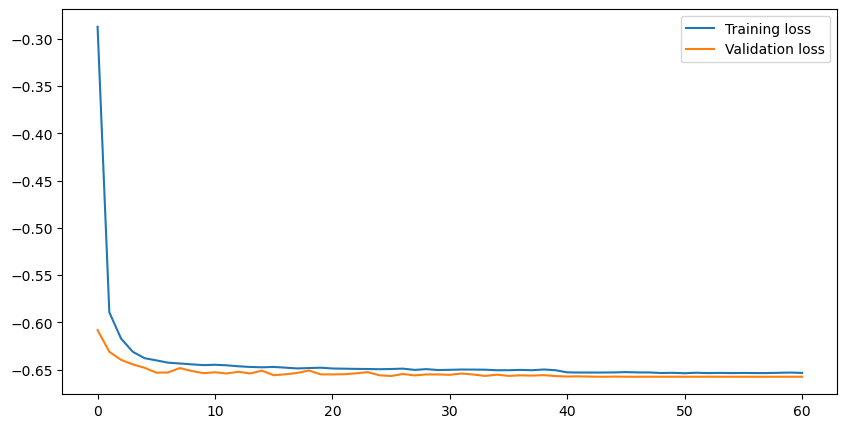

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [38]:
y_pred_mixture = mdn_network.predict(x)
print(y_pred_mixture.shape)

3855/3855 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
(123351, 60)


In [39]:
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info("Error sampling categorical model.")
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [40]:
# Sample from the predicted distributions
y_samples = np.apply_along_axis(
    sample_from_output, 1, y_pred_mixture, 1, N_MIXES, temp=1.0
)

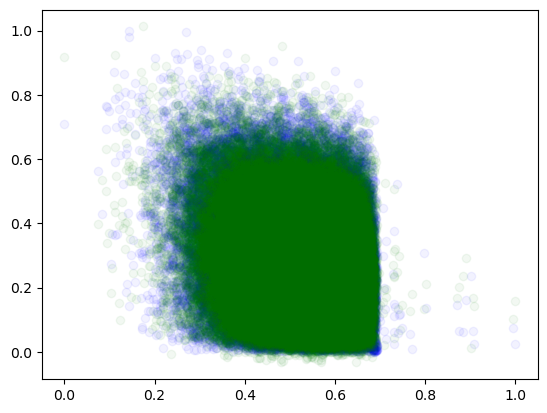

In [41]:
plt.scatter(x, y, alpha=0.05, color="blue", label="Ground Truth")
plt.scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
plt.show()

### Calculate Accomodation Co-efficients for MD and MDN data

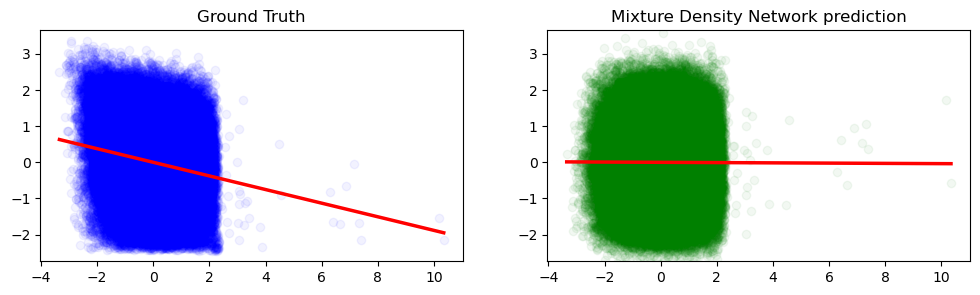

Slope: -0.18828510710078236, Intercept: -7.833217663005233e-16
Slope: -0.0036565042571288127, Intercept: 4.35284129215424e-16
AC for MD data: 1.1882851071007823, AC for MDN data: 1.0036565042571288


In [31]:
pt = PowerTransformer()

x_org = pt.fit_transform(x)
y_org = pt.fit_transform(y)
y_pred = pt.fit_transform(y_samples[:, :, 0])

x_org = [i[0] for i in x_org]
y_org = [i[0] for i in y_org]
y_new = [i[0] for i in y_pred]

# Regression fit of lines
m_MD, c_MD = np.polyfit(x_org, y_org, deg=1)
m_MDN, c_MDN = np.polyfit(x_org, y_new, deg=1)




# Plot scatter plots with regression line
xseq = np.linspace(min(x_org), max(x_org), num=100)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(12)
axs[0].set_title("Ground Truth")
axs[0].scatter(x_org, y_org, alpha=0.05, color="blue")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()
axs[0].plot(xseq, c_MD + m_MD * xseq, color="r", lw=2.5)

axs[1].scatter(
    x_org,
    y_new,
    color="green",
    alpha=0.05,
    label="Mixture Density Network prediction",
)
axs[1].set_title("Mixture Density Network prediction")
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
axs[1].plot(xseq, c_MDN + m_MDN * xseq, color="r", lw=2.5)
plt.show()

print(f"Slope: {m_MD}, Intercept: {c_MD}")
print(f"Slope: {m_MDN}, Intercept: {c_MDN}")

# Calculate ACs for MD and MDN data
AC_MD = 1 - m_MD
AC_MDN = 1 - m_MDN
print(f"AC for MD data: {AC_MD}, AC for MDN data: {AC_MDN}")